In [2]:
# ! pip install -U matplotlib
# ! pip install -U numpy
# ! pip install -U scipy
# ! pip install ipympl

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget

In [12]:
def plot(*args):
    ax = plt.figure()
    for idx in range(0, len(args), 2):
        x, y = args[idx], args[idx + 1]
        plt.plot(x, y)
    plt.grid(True)
    plt.ylabel('y')
    plt.xlabel('x')
    plt.show()

### Частотно-временные способы анализа сигналов с применением преобразованием Фурье


In [4]:
def dft(array: np.ndarray) -> np.ndarray:
    """ Discrete Fourier Transform"""
    def discrete_fourier_function(
        array: np.ndarray,
        k: int
    ) -> np.imag:

        def F(item, n):
            return item * np.e ** (
                (-1) * ((2 * np.pi * k * n * 1j) /
                        array.size - 1)
            )

        result = np.zeros(array.size, dtype=np.complex_)
        for idx in range(array.size):
            result[idx] = F(array[idx], idx)
        return np.sum(result)

    result = np.zeros(array.shape, dtype=np.complex_)
    for idx in range(array.size):
        result[idx] = discrete_fourier_function(array, idx)
    return result

In [5]:
def spectrum(array: np.ndarray) -> np.ndarray:
    tmp_freqs = np.abs(array)
    tmp_freqs = tmp_freqs[tmp_freqs.size // 2:]
    return 2 * tmp_freqs / array.size

In [6]:
def fragmentize(
        array: np.ndarray,
        size: int) -> np.ndarray:
    fragments = np.array_split(array, range(size, array.size, size))
    fragments = np.array(fragments)
    return fragments

In [7]:
def stft(array: np.ndarray):
    """Short Timed Fourier Transform"""
    tmp = []
    for part in array:
        tmp.append(spectrum(part))
    return np.array(tmp)

In [8]:
def y(x):
    if x < np.pi:
        return np.sin(0.5 * 2 * np.pi * x)
    else:
        return np.sin(0.8 * 2 * np.pi * x)

In [9]:
def make_bins(values: np.ndarray):
    """
    Создаём диапазоны для частей, 
    где за горизонтальное значение берётся
    индекс части, а по вертикали не/попадание
    в диапазон данных
    """
    bins = np.linspace(np.min(values), np.max(values), num=100)
    binned = np.zeros(shape=(bins.shape[0], values.shape[0]), dtype=np.int8)

    for line_idx in range(len(values)):
        for el_idx in range(values[line_idx].size):
            """Итерируемся по значениям частот"""
            current_value = values[line_idx, el_idx]

            for bin_idx in range(0, bins.size, 2):
                high_value = bins[bin_idx + 1]
                """
                Если частота попала в диапазон относительно
                большего значения поддиапозона, то выставляем попадание
                """
                if high_value >= current_value:
                    binned[bin_idx - 1, line_idx] = 1
                    break

    """Добавляем ещё одно значение для pcolormesh (иначе график не будет отрисовываться)"""
    bins = np.append(bins, np.max(values) + bins[0] - bins[1])
    return bins, binned

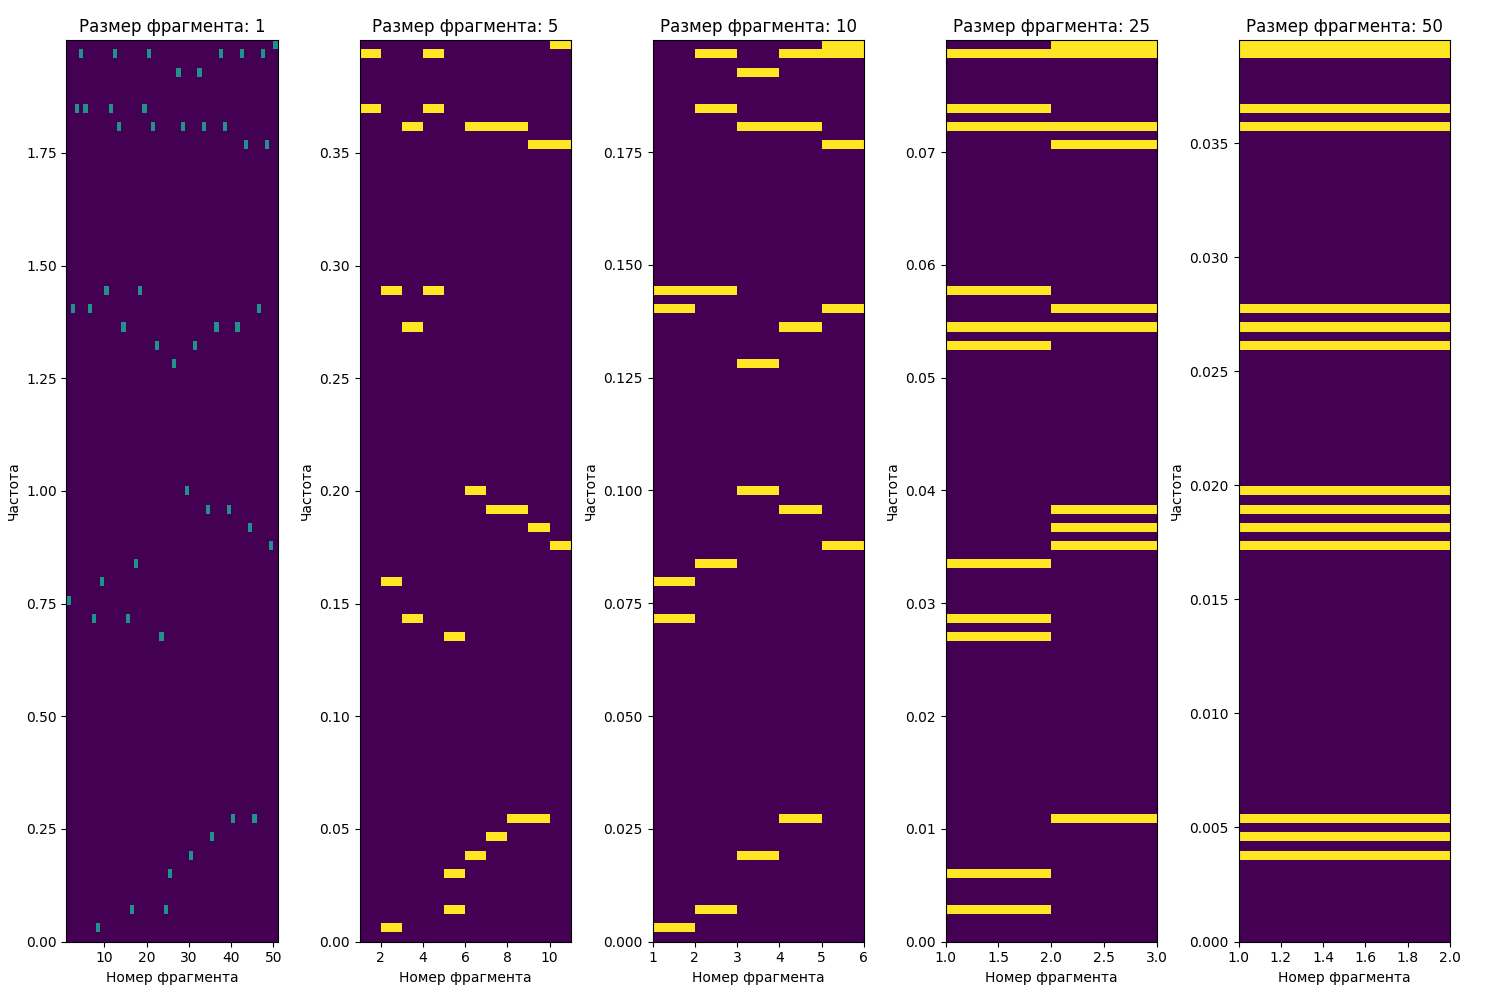

In [10]:
SAMPLES_COUNT = 50
signal_array = np.zeros(SAMPLES_COUNT)
for i in range(1, SAMPLES_COUNT):
    signal_array[i - 1] = y((2 * np.pi * i) / SAMPLES_COUNT)

SIZES = [1, 5, 10, 25, 50,]
fig, axs = plt.subplots(nrows=1, ncols=len(SIZES), figsize=(15, 10))
fig.tight_layout(pad=2.5)
for idx, size in enumerate(SIZES):
    fragment_size = size
    fragments = fragmentize(signal_array, fragment_size)
    stft_array = stft(fragments)

    bins, values = make_bins(stft_array)
    x_graph = np.arange(1, fragments.shape[0] + 2)
    y_graph = bins
    z_graph = values

    axs[idx].set_title(f'Размер фрагмента: {fragment_size}')
    axs[idx].set_ylabel(f'Частота')
    axs[idx].set_xlabel(f'Номер фрагмента')
    axs[idx].pcolormesh(
        x_graph,
        y_graph,
        z_graph,
        shading='flat',
        vmin=stft_array.min(),
        vmax=stft_array.max())

### Оконное преобразование Фурье


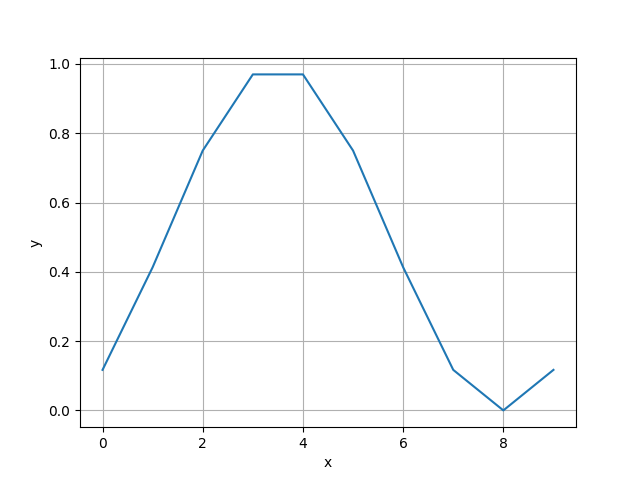

In [13]:
def hem_window(N: int) -> np.ndarray:
    result = np.arange(start=1, stop=N + 1)
    result = 0.5 * (1 - np.cos(2 * ((np.pi * result) / (N - 1))))
    return result


N = 10
plot(np.arange(N), hem_window(N))

In [14]:
def wft(array: np.ndarray,
        m: int,
        hem_window_array: np.ndarray) -> np.ndarray:
    """ Windowed Fourier Transform.

    Positional arguments
    array -- массив всех частей
    m -- индекс текущей части
    hem_window_array -- массив окна Хэмминга
    """
    def _wft(
        k: int,
    ) -> np.imag:

        def window(n: int, m: int):
            """ Обнуление окна, если индекс выходит за границы массива"""
            if (
                n - m >= 0
                and
                n - m < hem_window_array.size
            ):
                return hem_window_array[n - m]
            return 0

        def F(item, n):
            return item * window(n, m) * np.e ** (
                (-1) * ((2 * np.pi * k * n * 1j) /
                        array.size - 1)
            )

        result = np.zeros(array.size, dtype=np.complex_)
        for idx in range(array.size):
            result[idx] = F(array[idx], idx)
        return np.sum(result)

    result = np.zeros(array.shape, dtype=np.complex_)
    for idx in range(array.size):
        result[idx] = _wft(idx)

    return result

In [15]:
def wsp(array: np.ndarray,
        window_size: int):
    """ Windowed Spectrum """

    def _wsp(part_idx):
        tmp = wft(array, part_idx, hem_window(window_size))
        tmp = np.abs(tmp)
        tmp = tmp[tmp.size // 2:]
        return 2 * tmp / array.size

    result = []
    for idx in range(array.size):
        result.append(_wsp(idx))
    return np.array(result)

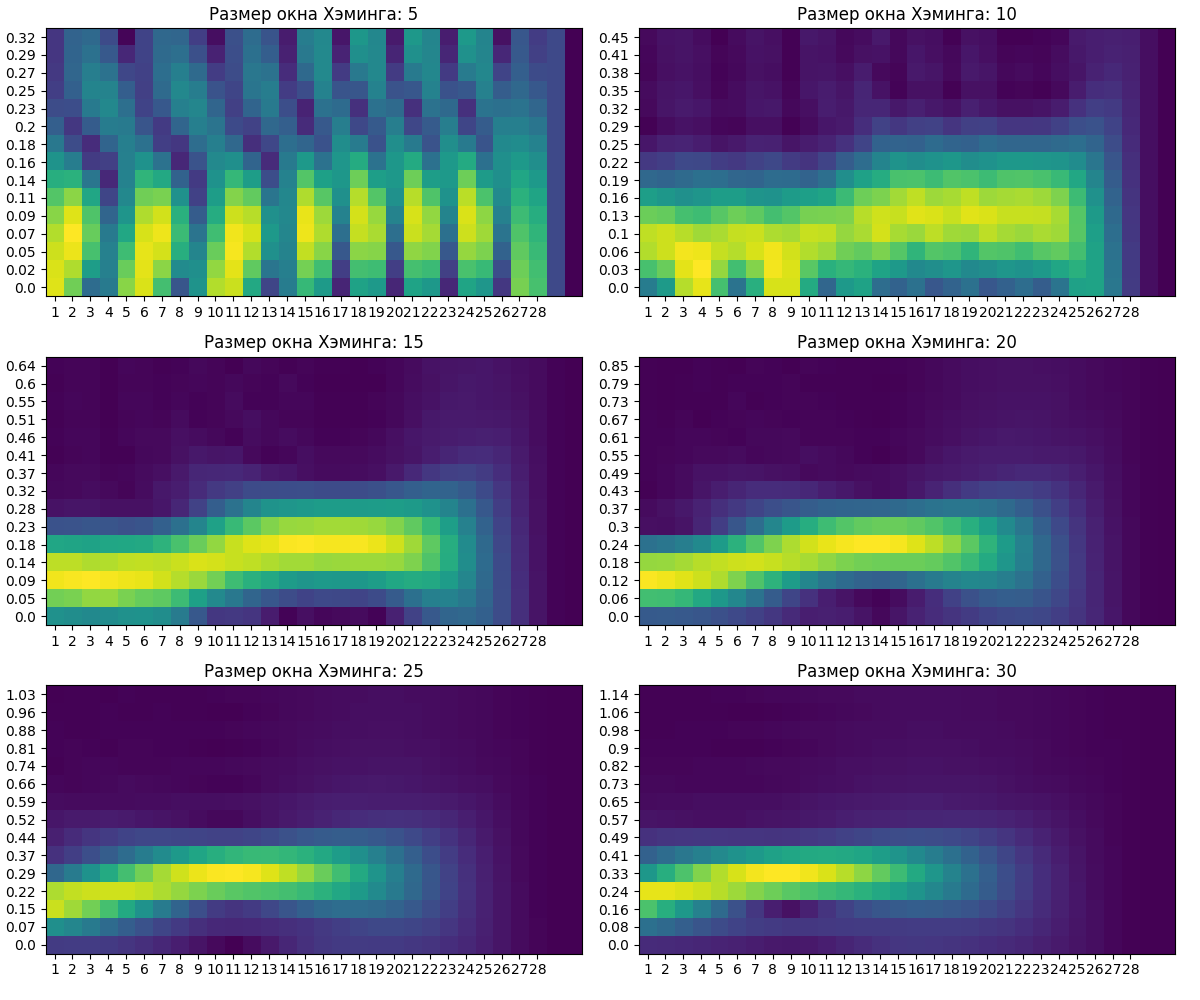

In [23]:
SAMPLES_COUNT = 30
WINDOW_STEP = 5
fig, axs = plt.subplots(ncols=2, nrows=(SAMPLES_COUNT // WINDOW_STEP) // 2, figsize=(12, 10))
fig.tight_layout(pad=1)
for idx, ax in enumerate(axs.ravel()):
    window_size = (idx + 1) * WINDOW_STEP
    signal_array = np.zeros(SAMPLES_COUNT)
    for i in range(1, SAMPLES_COUNT):
        signal_array[i - 1] = y((2 * np.pi * i) / SAMPLES_COUNT)

    spectrums = wsp(signal_array, window_size)
    spectrums = spectrums.T
    x_range = np.arange(start=1, stop=SAMPLES_COUNT - 1)
    y_bins = np.linspace(start=spectrums.min(), stop=spectrums.max(), num=spectrums.shape[0])
    y_bins = np.flip(y_bins)
    y_bins = np.round(y_bins, decimals=2)

    im = ax.imshow(spectrums)
    ax.set_xticks(np.arange(len(x_range)), labels=x_range)
    ax.set_yticks(np.arange(len(y_bins)), labels=y_bins)
    ax.set_title(f"Размер окна Хэминга: {window_size}")
plt.show()